# Approximate Runge function with NN and calculate derivative directly

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
import random
import pandas as pd

## Define Runge Function & Its Derivative

In [141]:
f = lambda x: 1 / (1+25*x**2)
df = lambda x: -50*x / (1+25*x**2)**2

## Produce Data

We produce 1024 samples in training set and 256 samples in validation set.

```.unsqueeze(1)``` is to convert the size to a $n\times 1$ matrix.

In [142]:
n_train, n_val = 1024, 256
Xtr = torch.linspace(-1, 1, n_train).unsqueeze(1)
ytr = f(Xtr)
Xva = torch.linspace(-1, 1, n_val).unsqueeze(1)
yva = f(Xva)

## Define Model
Here, we set the neural network to be 3 layers including 1 input layer, 1 hidden layer and 1 output layer, each has 16 neurons except the output layer.

$\tanh(x)$ function is chosen to be the activation function.

Also, we use Adam optimizer to modify learning rate as the changing of gradient.

In [143]:
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, 16), nn.Tanh(), nn.Linear(16, 1))

mse = nn.MSELoss() # Define MSE loss function
opt = optim.Adam(model.parameters(), lr=3e-3) # optimizer


## Training & Validation
We train for 2000 times, each time we do:
* ```opt.zero_grad()``` to rest the gradient
* ```mse(model(Xtr), ytr)``` to calculate the MSE loss of training set
* ```loss.backward()``` to calculate the gradient
* ```opt.step()``` to update the parameters according to the gradient
* Next, calculte the MSE loss of validation set without updating parameters
* Save the losses to plot

In [144]:
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # training step
    opt.zero_grad()
    loss = mse(model(Xtr), ytr)
    loss.backward()
    opt.step()

    # validation step
    with torch.no_grad():
        val_loss = mse(model(Xva), yva).item()
    
    train_losses.append(loss.item())
    val_losses.append(val_loss)

## Graphing
First, we use ```touch.autograd.grad()``` to output the derivative of NN(x) for x in test point. Therefore, we can plot the true derivative and that given by NN(x)

MAX error = 0.137344
RMSE      = 1.454198


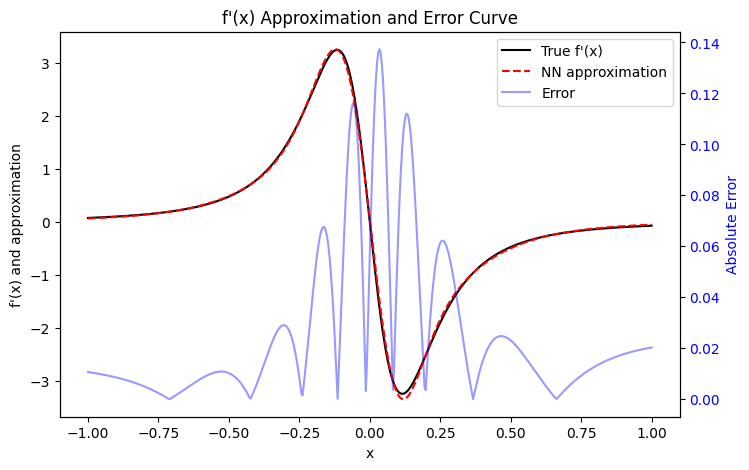

In [145]:
# ---- Function approximation and Error curve ----
X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

# --- 計算網路的導函數 ---
X_test.requires_grad_(True)             # 讓 autograd 能對 x 求導
y_pred = model(X_test)                  # NN 輸出
grad = torch.autograd.grad(
    outputs=y_pred, inputs=X_test,
    grad_outputs=torch.ones_like(y_pred),  # dy/dy = 1
    create_graph=False, retain_graph=False
)[0] 

y_true = df(X_test)  # True derivative
error = torch.abs(y_true - grad)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), y_true.detach().numpy(), color="black", label="True f'(x)")
ax1.plot(X_test.detach().numpy(), grad.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'(x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f'(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")

# Approximate Runge function and its derivative simutaneously with NN

## Define Runge Function & Its Derivative

In [146]:
f = lambda x: 1 / (1+25*x**2)
df = lambda x: -50*x / (1+25*x**2)**2

## Produce Data

We produce 1024 samples in training set and 256 samples in validation set.

```.unsqueeze(1)``` is to convert the size to a $n\times 1$ matrix.

In [147]:
n_train, n_val = 1024, 256
Xtr = torch.linspace(-1, 1, n_train).unsqueeze(1)
ytr = f(Xtr)
dytr = df(Xtr)
Xva = torch.linspace(-1, 1, n_val).unsqueeze(1)
yva = f(Xva)
dyva = df(Xva)

## Define Model
Here, we set the neural network to be 3 layers including 1 input layer, 1 hidden layers and 1 output layer, each has 16 neurons except the output layer.

$\tanh(x)$ function is chosen to be the activation function.

Also, we use Adam optimizer to modify learning rate as the changing of gradient.


In [148]:
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# model = nn.Sequential(nn.Linear(1, 32), nn.Tanh(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 1))
model = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, 16), nn.Tanh(), nn.Linear(16, 1))

opt = optim.Adam(model.parameters(), lr=3e-3) # optimizer


## Training & Validation
We train for 2000 times, each time we do:
* ```opt.zero_grad()``` to rest the gradient
* ```mse(model(Xtr), ytr)``` to calculate the MSE loss of training set
* ```loss.backward()``` to calculate the gradient
* ```opt.step()``` to update the parameters according to the gradient
* Next, calculte the MSE loss of function value and derivative of validation set without updating parameters

$MSE Loss = \alpha\sum_{i} (f(x)-NN(x))^2 + \beta\sum_{i} (f'(x)-NN'(x))^2$

Here we choose $\alpha = \beta = 1$

* Save the losses to plot

In [149]:
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    Xtr.requires_grad_(True) # Enable gradient tracking
    
    y_pred = model(Xtr)
    dy_pred = torch.autograd.grad(
        outputs=y_pred, inputs=Xtr,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True, retain_graph=True
    )[0]

    # Define combined loss
    loss_fn = nn.MSELoss()
    loss = 1 * loss_fn(y_pred, ytr) + 1 * loss_fn(dy_pred, dytr)
    
    # training step
    opt.zero_grad()
    loss.backward()
    opt.step()

    # validation step
    model.eval()
    Xva.requires_grad_(True)
    y_pred_val = model(Xva)
    dy_pred_val = torch.autograd.grad(y_pred_val, Xva,
                                    grad_outputs=torch.ones_like(y_pred_val),
                                    create_graph=False)[0]
    loss_val = loss_fn(y_pred_val, yva) + loss_fn(dy_pred_val, dyva)

    train_losses.append(loss.item())
    val_losses.append(loss_val.item())

## Graphing
First, we use ```touch.autograd.grad()``` to output the derivative of NN(x) for x in test point. Therefore, we can plot the true derivative and that given by NN(x)

-----------f(x)-----------
MAX error = 0.000177
RMSE      = 0.000090
-----------f'(x)-----------
MAX error = 0.005267
RMSE      = 1.454200


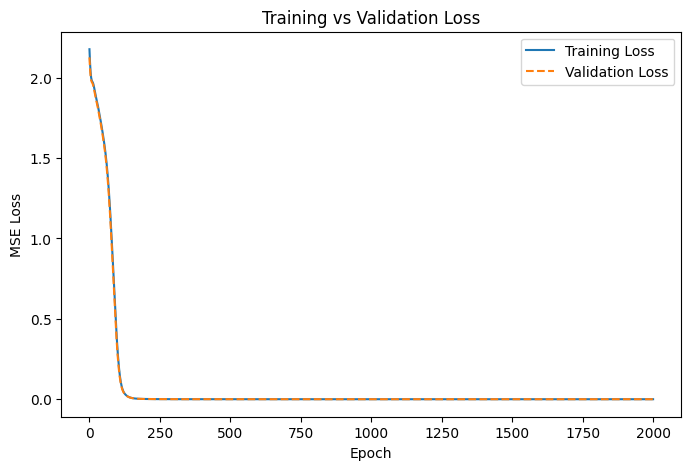

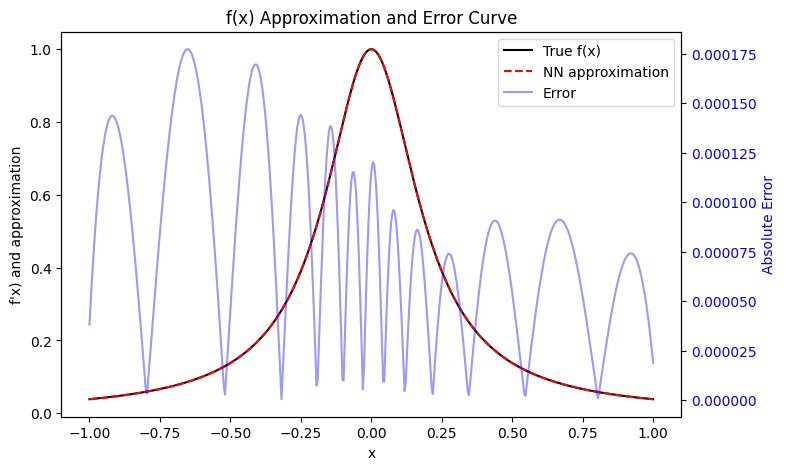

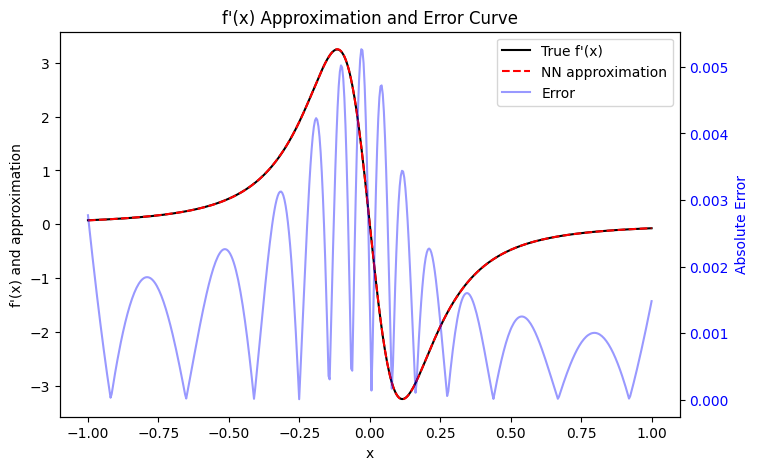

In [150]:
# ---- Training/Validation loss ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ---- f(x) approximation and Error curve ----
X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

y_true = f(X_test)  # True function value
y_pred = model(X_test)
error = torch.abs(y_true - y_pred)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), y_true.detach().numpy(), color="black", label="True f(x)")
ax1.plot(X_test.detach().numpy(), y_pred.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
print('-----------f(x)-----------')
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")



# ---- f'(x) approximation and Error curve ----
# X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

# --- 計算網路的導函數 ---
X_test.requires_grad_(True)             # 讓 autograd 能對 x 求導
dy_pred = model(X_test)                  # NN 輸出
grad = torch.autograd.grad(
    outputs=dy_pred, inputs=X_test,
    grad_outputs=torch.ones_like(y_pred),  # dy/dy = 1
    create_graph=False, retain_graph=False
)[0] 

dy_true = df(X_test)  # True derivative
error = torch.abs(dy_true - grad)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), dy_true.detach().numpy(), color="black", label="True f'(x)")
ax1.plot(X_test.detach().numpy(), grad.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'(x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f'(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((dy_true - dy_pred)**2).mean()).item()
print("-----------f'(x)-----------")
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")

# Comparison

## Different NN settings
Now, we use 4 layers including 1 input layer, 2 hidden layers and 1 output layer. There are 32 neurons in each hidden layer, which increases the complexity of NN

It seems that there is not obvious changes.

-----------f(x)-----------
MAX error = 0.000128
RMSE      = 0.000066
-----------f'(x)-----------
MAX error = 0.001863
RMSE      = 1.454202


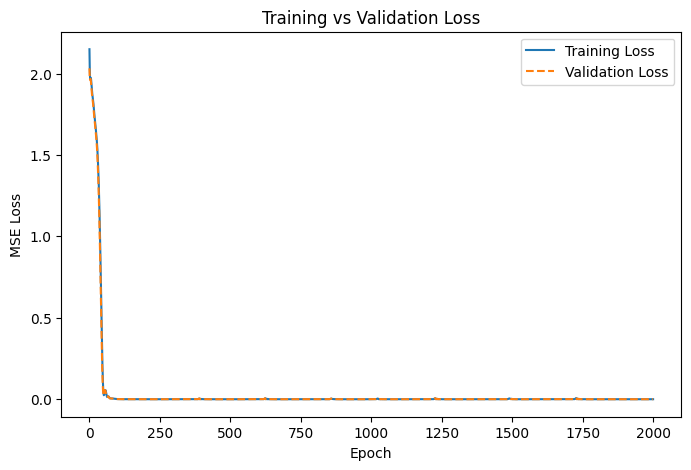

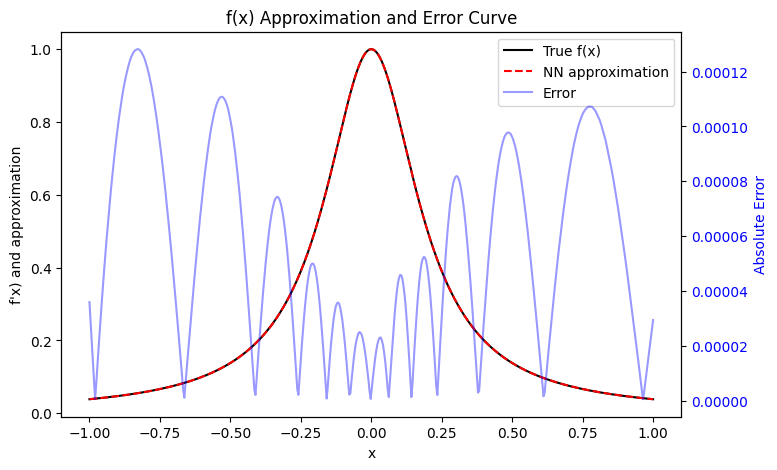

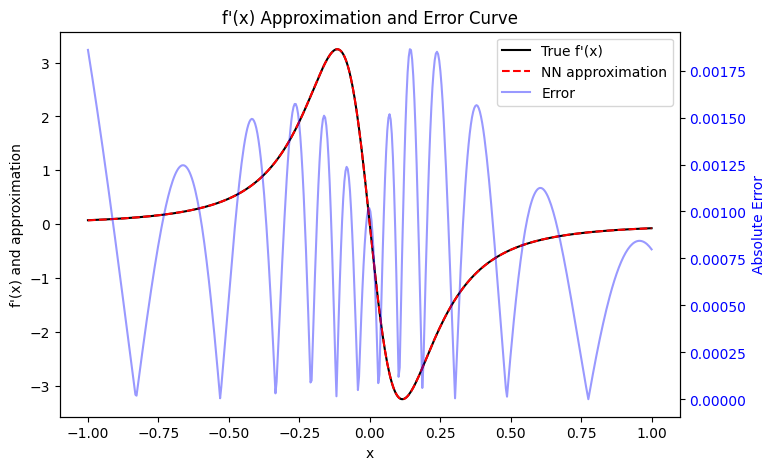

In [151]:
# Define Model
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model = nn.Sequential(nn.Linear(1, 32), nn.Tanh(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 1))

opt = optim.Adam(model.parameters(), lr=3e-3) # optimizer


# Train & Validation
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    Xtr.requires_grad_(True) # Enable gradient tracking
    
    y_pred = model(Xtr)
    dy_pred = torch.autograd.grad(
        outputs=y_pred, inputs=Xtr,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True, retain_graph=True
    )[0]

    # Define combined loss
    loss_fn = nn.MSELoss()
    loss = 1 * loss_fn(y_pred, ytr) + 1 * loss_fn(dy_pred, dytr)
    
    # training step
    opt.zero_grad()
    loss.backward()
    opt.step()

    # validation step
    model.eval()
    Xva.requires_grad_(True)
    y_pred_val = model(Xva)
    dy_pred_val = torch.autograd.grad(y_pred_val, Xva,
                                    grad_outputs=torch.ones_like(y_pred_val),
                                    create_graph=False)[0]
    loss_val = loss_fn(y_pred_val, yva) + loss_fn(dy_pred_val, dyva)

    train_losses.append(loss.item())
    val_losses.append(loss_val.item())

    # Graphing
    # ---- Training/Validation loss ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ---- f(x) approximation and Error curve ----
X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

y_true = f(X_test)  # True function value
y_pred = model(X_test)
error = torch.abs(y_true - y_pred)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), y_true.detach().numpy(), color="black", label="True f(x)")
ax1.plot(X_test.detach().numpy(), y_pred.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
print('-----------f(x)-----------')
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")



# ---- f'(x) approximation and Error curve ----
# X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

# --- 計算網路的導函數 ---
X_test.requires_grad_(True)             # 讓 autograd 能對 x 求導
dy_pred = model(X_test)                  # NN 輸出
grad = torch.autograd.grad(
    outputs=dy_pred, inputs=X_test,
    grad_outputs=torch.ones_like(y_pred),  # dy/dy = 1
    create_graph=False, retain_graph=False
)[0] 

dy_true = df(X_test)  # True derivative
error = torch.abs(dy_true - grad)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), dy_true.detach().numpy(), color="black", label="True f'(x)")
ax1.plot(X_test.detach().numpy(), grad.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'(x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f'(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((dy_true - dy_pred)**2).mean()).item()
print("-----------f'(x)-----------")
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")

## Increase Iteration of Training
Use original NN but increase the iterations to 10000

-----------f(x)-----------
MAX error = 0.000333
RMSE      = 0.000148
-----------f'(x)-----------
MAX error = 0.001709
RMSE      = 1.454244


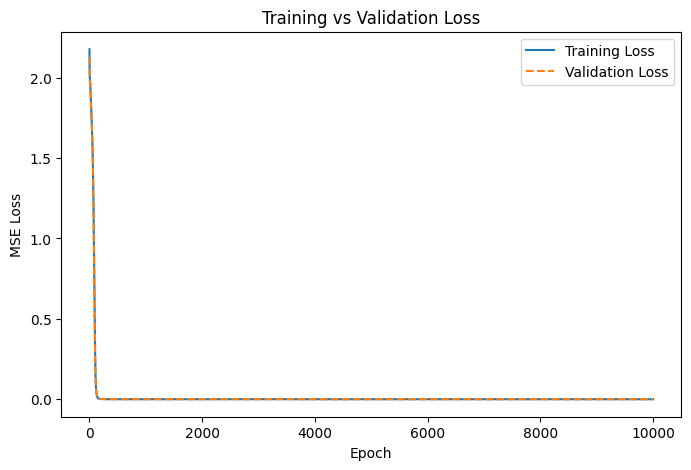

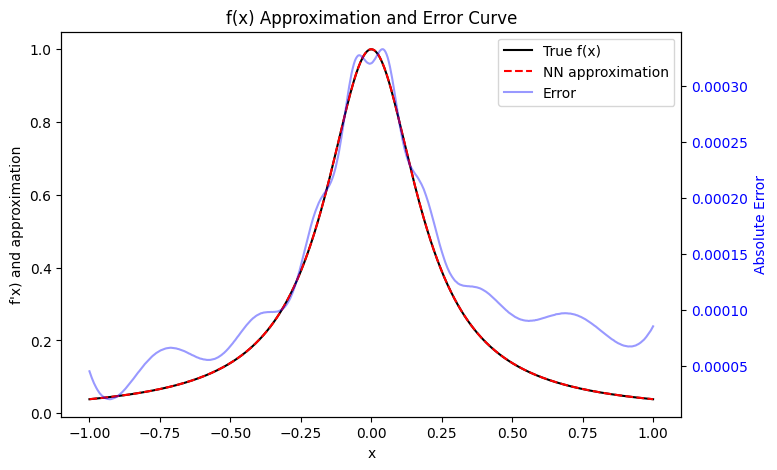

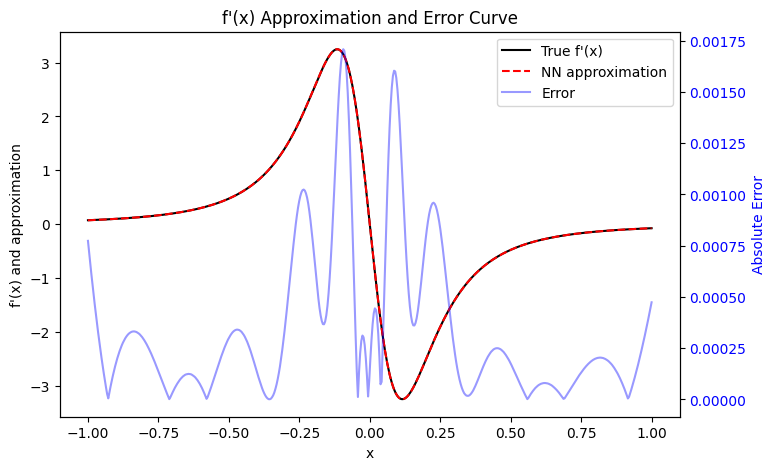

In [152]:
# Define Model
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, 16), nn.Tanh(), nn.Linear(16, 1))

opt = optim.Adam(model.parameters(), lr=3e-3) # optimizer


# Train & Validation
epochs = 10000
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    Xtr.requires_grad_(True) # Enable gradient tracking
    
    y_pred = model(Xtr)
    dy_pred = torch.autograd.grad(
        outputs=y_pred, inputs=Xtr,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True, retain_graph=True
    )[0]

    # Define combined loss
    loss_fn = nn.MSELoss()
    loss = 1 * loss_fn(y_pred, ytr) + 1 * loss_fn(dy_pred, dytr)
    
    # training step
    opt.zero_grad()
    loss.backward()
    opt.step()

    # validation step
    model.eval()
    Xva.requires_grad_(True)
    y_pred_val = model(Xva)
    dy_pred_val = torch.autograd.grad(y_pred_val, Xva,
                                    grad_outputs=torch.ones_like(y_pred_val),
                                    create_graph=False)[0]
    loss_val = loss_fn(y_pred_val, yva) + loss_fn(dy_pred_val, dyva)

    train_losses.append(loss.item())
    val_losses.append(loss_val.item())

    # Graphing
    # ---- Training/Validation loss ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ---- f(x) approximation and Error curve ----
X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

y_true = f(X_test)  # True function value
y_pred = model(X_test)
error = torch.abs(y_true - y_pred)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), y_true.detach().numpy(), color="black", label="True f(x)")
ax1.plot(X_test.detach().numpy(), y_pred.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
print('-----------f(x)-----------')
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")



# ---- f'(x) approximation and Error curve ----
# X_test = torch.linspace(-1, 1, 500).unsqueeze(1)

# --- 計算網路的導函數 ---
X_test.requires_grad_(True)             # 讓 autograd 能對 x 求導
dy_pred = model(X_test)                  # NN 輸出
grad = torch.autograd.grad(
    outputs=dy_pred, inputs=X_test,
    grad_outputs=torch.ones_like(y_pred),  # dy/dy = 1
    create_graph=False, retain_graph=False
)[0] 

dy_true = df(X_test)  # True derivative
error = torch.abs(dy_true - grad)       # Absolute error

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Left: approximation ---
ax1.plot(X_test.detach().numpy(), dy_true.detach().numpy(), color="black", label="True f'(x)")
ax1.plot(X_test.detach().numpy(), grad.detach().numpy(), color="red", linestyle="--", label="NN approximation")
ax1.set_xlabel("x")
ax1.set_ylabel("f'(x) and approximation", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# --- Right: error ---
ax2 = ax1.twinx()
ax2.plot(X_test.detach().numpy(), error.detach().numpy(), color="blue", label="Error", alpha=0.4)
ax2.set_ylabel("Absolute Error", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# --- Combine ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("f'(x) Approximation and Error Curve")

# ---- Max error and RMSE ----
max_error = error.max().item()
rmse = torch.sqrt(((dy_true - dy_pred)**2).mean()).item()
print("-----------f'(x)-----------")
print(f"MAX error = {max_error:.6f}")
print(f"RMSE      = {rmse:.6f}")